In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import re
import io
import json
import pandas as pd  # <-- BỔ SUNG THƯ VIỆN
import seaborn as sns # <-- BỔ SUNG THƯ VIỆN

# --- Cài đặt Matplotlib theo yêu cầu của bạn ---
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['axes.unicode_minus'] = False

# --- 1. Hàm tạo dữ liệu giả (Mô phỏng) ---

def load_fake_data(num_samples=500):
    """
    Tạo ra một danh sách dữ liệu giả mạo (list of dicts) 
    mô phỏng cấu trúc JSON của bạn.
    """
    print(f"Generating {num_samples} fake data samples...")
    fake_data = []
    q_types = ["What", "How many", "When", "Which", "Who", "Where", "Why", "Is"]

    for i in range(num_samples):
        # 1. Tạo layouts
        num_elements = random.randint(2, 8)
        num_texts = random.randint(3, 10)
        
        layers = []
        
        # Base layer (image dims)
        img_height = random.randint(800, 1600)
        img_width = random.randint(800, 1200)
        layers.append({
            "category": "base",
            "bottom_right": [img_height, img_width]
        })
        
        # Element layers
        for _ in range(num_elements):
            layers.append({"category": "element"})
            
        # Text layers
        for _ in range(num_texts):
            layers.append({"category": "text", "text": "Fake text " * random.randint(3, 10)})

        # 2. Tạo Q&A pairs
        num_qa = random.randint(4, 15)
        qa_pairs = []
        for _ in range(num_qa):
            q_type = random.choice(q_types)
            question = f"{q_type} is this a fake question number {random.randint(1, 100)}?"
            answer_text = "Fake answer " * random.randint(1, 6)
            qa_pairs.append({
                "question": question,
                "answers": {"text": [answer_text.strip()]}
            })

        # 3. Tạo item hoàn chỉnh
        fake_data.append({
            "index": i,
            "layers_all": layers,
            "original_qa_pairs": qa_pairs
        })
        
    print("Fake data generation complete.")
    return fake_data

# --- 2. Hàm phân tích dữ liệu ---

def analyze_data(data):
    """
    Phân tích danh sách dữ liệu và trích xuất các thông tin thống kê.
    """
    stats = {
        "image_widths": [],
        "image_heights": [],
        "num_elements": [],
        "num_texts": [],
        "num_qa_pairs": [],
        "question_lengths": [],
        "answer_lengths": [],
        "question_types": []
    }

    for item in data:
        # Lấy kích thước ảnh từ layer 'base'
        base_layer = next((l for l in item['layers_all'] if l['category'] == 'base'), None)
        if base_layer:
            stats['image_heights'].append(base_layer['bottom_right'][0])
            stats['image_widths'].append(base_layer['bottom_right'][1])

        # Đếm số lượng layout
        stats['num_elements'].append(sum(1 for l in item['layers_all'] if l['category'] == 'element'))
        stats['num_texts'].append(sum(1 for l in item['layers_all'] if l['category'] == 'text'))

        # Phân tích Q&A
        qa_pairs = item['original_qa_pairs']
        stats['num_qa_pairs'].append(len(qa_pairs))
        
        for qa in qa_pairs:
            q = qa['question']
            ans = qa['answers']['text'][0]
            
            # Lấy độ dài (số từ)
            stats['question_lengths'].append(len(q.split()))
            stats['answer_lengths'].append(len(ans.split()))
            
            # Phân loại câu hỏi (lấy từ đầu tiên)
            match = re.match(r'^(\w+)', q)
            if match:
                stats['question_types'].append(match.group(1))

    return stats


def plot_dataset_statistics(stats):
    """
    Vẽ biểu đồ cột (bar chart) các thống kê trung bình của dataset.
    (Tương tự hình c)
    """
    # Tính toán giá trị trung bình
    avg_stats = {
        "Avg. Element Layouts": np.mean(stats['num_elements']),
        "Avg. Text Layouts": np.mean(stats['num_texts']),
        "Avg. Q&A Pairs": np.mean(stats['num_qa_pairs']),
        "Avg. Question Length": np.mean(stats['question_lengths']),
        "Avg. Answer Length": np.mean(stats['answer_lengths']),
    }
    
    labels = list(avg_stats.keys())
    values = list(avg_stats.values())
    
    # Màu sắc tương tự style
    colors = ['#ffb3ba', '#ffdfba', '#ffffba', '#baffc9', '#baebff', '#ccbaff', '#f9c6ff']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(labels, values, color=colors)
    
    # Xoay nhãn trục X để dễ đọc
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
    ax.set_ylabel("Average Value", fontsize=12)
    ax.set_title("Average Dataset Statistics", fontsize=16, pad=20)
    
    # Tắt gai (spines) bên phải và bên trên cho sạch
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Thêm giá trị lên trên mỗi cột
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + (max(values) * 0.01), 
                f'{yval:.1f}', 
                ha='center', 
                va='bottom',
                fontsize=11)

    plt.tight_layout()
    # --- THAY ĐỔI: LƯU SVG VÀ PDF ---
    plt.savefig("dataset_statistics.pdf", bbox_inches='tight')
    plt.savefig("dataset_statistics.svg", bbox_inches='tight')
    print("Đã lưu 'dataset_statistics.pdf' và 'dataset_statistics.svg'")

def plot_reasoning_length_comparison(reasoning_data):
    """
    Vẽ biểu đồ cột so sánh độ dài trung bình của reasoning cho 4 phiên bản.
    """
    labels = list(reasoning_data.keys())
    values = list(reasoning_data.values())
    
    # Chọn 4 màu
    colors = ['#baffc9', '#baebff', '#ccbaff', '#f9c6ff']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    bars = ax.bar(labels, values, color=colors)
    
    ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=12)
    ax.set_ylabel("Average Reasoning Length (words)", fontsize=12)
    ax.set_title("Average Reasoning Length Comparison", fontsize=16, pad=20)
    
    # Tắt gai (spines)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Thêm giá trị lên trên mỗi cột
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + (max(values) * 0.01), 
                f'{yval:.1f}', 
                ha='center', 
                va='bottom',
                fontsize=11)

    plt.tight_layout()
    # --- LƯU SVG VÀ PDF CHO BIỂU ĐỒ MỚI ---
    plt.savefig("reasoning_length_comparison.pdf", bbox_inches='tight')
    plt.savefig("reasoning_length_comparison.svg", bbox_inches='tight')
    print("Đã lưu 'reasoning_length_comparison.pdf' và 'reasoning_length_comparison.svg'")


# --- 3. Hàm vẽ biểu đồ (Tiếp theo) ---

def simulate_layout_data(num_samples):
    """
    Giả lập dữ liệu layout (element, text) cho bubble chart.
    Sử dụng phân phối chuẩn để dữ liệu có xu hướng tụ lại.
    """
    data = []
    # Giả lập tâm của cụm dữ liệu
    mean_elements = random.uniform(3, 8)
    mean_texts = random.uniform(5, 12)
    
    for _ in range(num_samples):
        # Tạo số element và text dựa trên phân phối chuẩn
        num_elements = int(np.random.normal(loc=mean_elements, scale=2.0))
        num_texts = int(np.random.normal(loc=mean_texts, scale=3.0))
        
        # Đảm bảo giá trị không bị âm hoặc bằng 0
        num_elements = max(1, num_elements)
        num_texts = max(1, num_texts)
        
        data.append((num_elements, num_texts))
    return data


# --- 4. Chạy chương trình ---

if __name__ == "__main__":
    # 1. Tạo hoặc tải dữ liệu
    # Thay hàm này bằng hàm đọc dữ liệu thật của bạn khi có
    # data = load_real_data("root_dir/templates/")
    data = load_fake_data(num_samples=1000) # Tạo 1000 sample giả

    # 2. Phân tích dữ liệu
    statistics = analyze_data(data)

    plot_dataset_statistics(statistics)
    
    # Dữ liệu 4 phiên bản như bạn cung cấp
    reasoning_data = {
        "Version 1": 15,
        "Version 2": 120,
        "Version 3": 150,
        "Version 4": 200
    }
    plot_reasoning_length_comparison(reasoning_data)
    
    print("\nGenerating and plotting layout bubble charts...")
    
    # 4.1. Giả lập dữ liệu (1000 cho train, 300 cho val)
    train_layout_data = simulate_layout_data(1000)
    val_layout_data = simulate_layout_data(300)
    



    # 4.4. Hiển thị tất cả
    plt.show()
    
    
    plt.show()

--- Chạy Phân tích Thống kê (Dữ liệu Thật) ---
Loading data from /home/thinhnp/hf_vqa/dataset/templates and /home/thinhnp/hf_vqa/dataset/qas...
Loaded 1954 templates.
Merged 1954 QA items.


/tmp/ipykernel_436832/2698879992.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)


Đã lưu 'dataset_statistics.pdf' và 'dataset_statistics.svg'

--- Chạy Biểu đồ So sánh Reasoning (Dữ liệu Gán cứng) ---


/tmp/ipykernel_436832/2698879992.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=12)


Đã lưu 'reasoning_length_comparison.pdf' và 'reasoning_length_comparison.svg'

--- Chạy Biểu đồ Phân bố Layout (Dữ liệu Thật .jsonl) ---
Đã lưu 'layout_distribution_train.pdf' và 'layout_distribution_train.svg'
Đã lưu 'layout_distribution_test.pdf' và 'layout_distribution_test.svg'

--- Hoàn tất ---


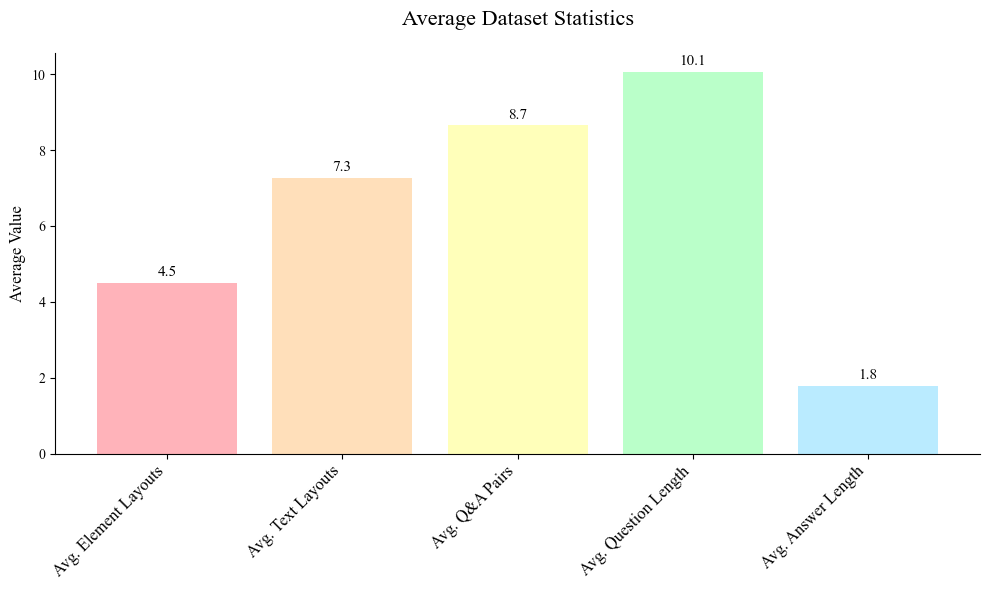

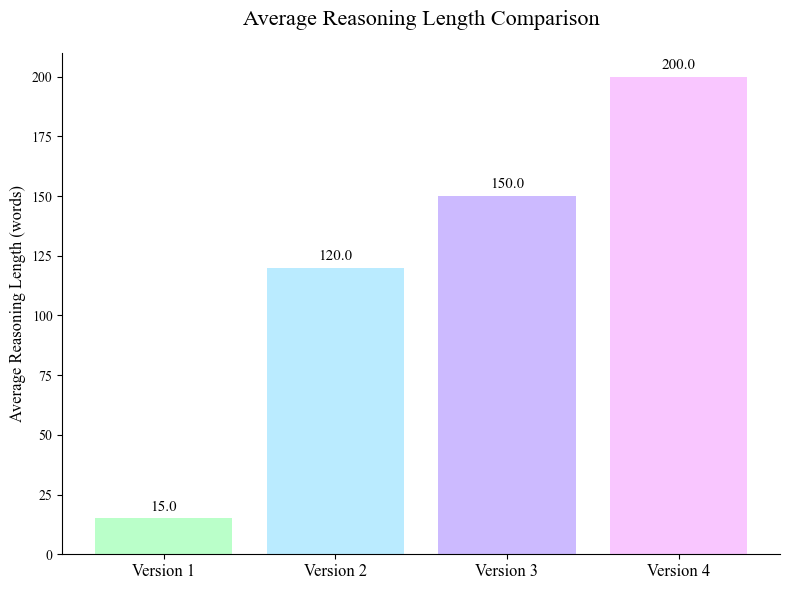

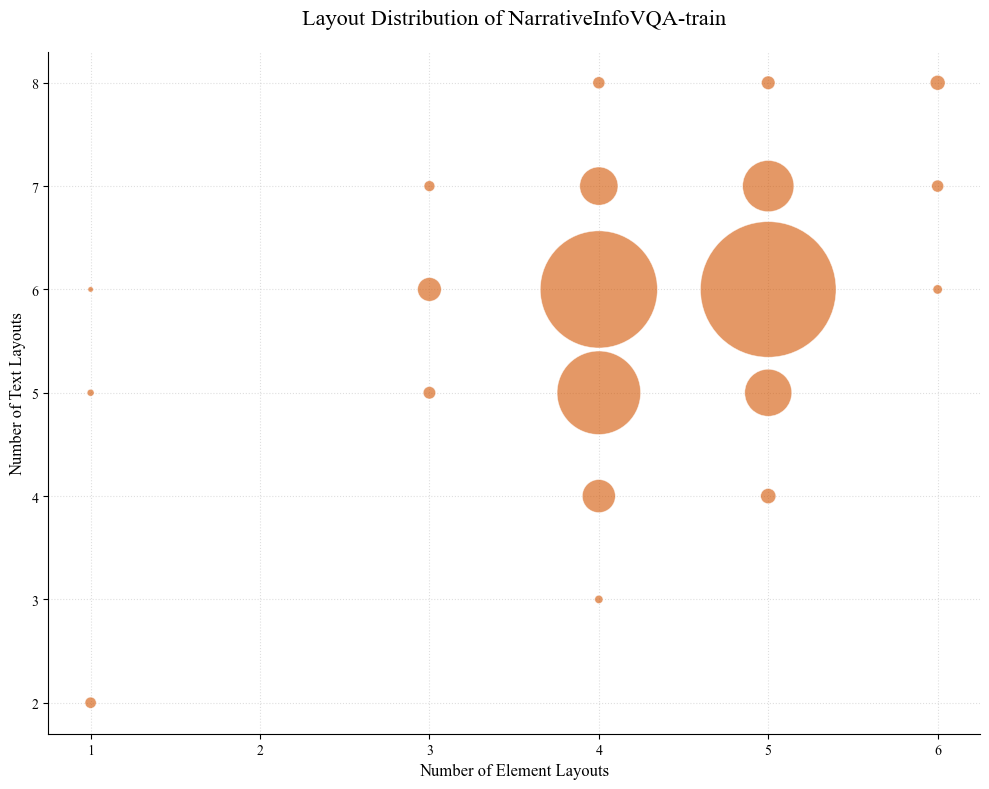

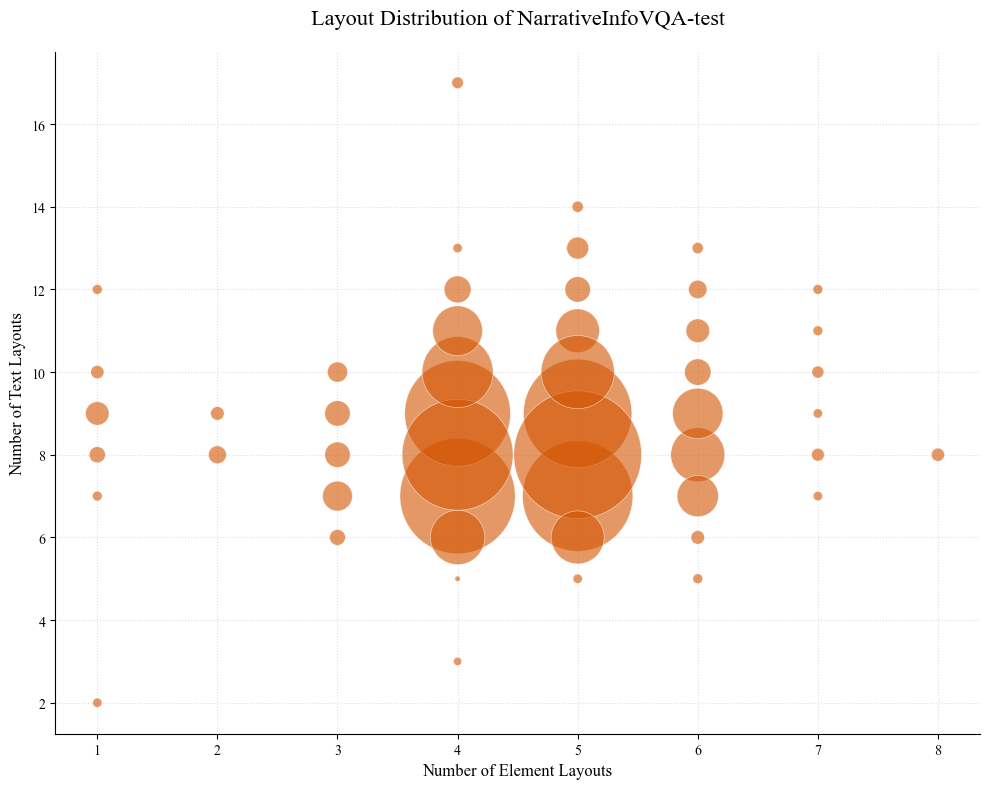

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import re
import json
from pathlib import Path

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['axes.unicode_minus'] = False

# === PHẦN 1: TẢI VÀ PHÂN TÍCH DỮ LIỆU THỐNG KÊ (THẬT) ===

def load_real_data(templates_dir, qas_dir):
    print(f"Loading data from {templates_dir} and {qas_dir}...")
    data_map = {}
    
    template_path = Path(templates_dir)
    for json_file in template_path.glob("*.json"):
        with open(json_file, 'r', encoding='utf-8') as f:
            template_data = json.load(f)
            infographic_id = template_data.get("infographic_id")
            if infographic_id is not None:
                data_map[infographic_id] = template_data
    
    print(f"Loaded {len(data_map)} templates.")

    qa_path = Path(qas_dir)
    items_merged = 0
    for json_file in qa_path.glob("*.json"):
        with open(json_file, 'r', encoding='utf-8') as f:
            qa_data = json.load(f)
            infographic_id = qa_data.get("infographic_id")
            
            if infographic_id in data_map:
                data_map[infographic_id].update(qa_data)
                items_merged += 1
    
    print(f"Merged {items_merged} QA items.")
    return list(data_map.values())

def analyze_data(data):
    stats = {
        "image_widths": [], "image_heights": [],
        "num_elements": [], "num_texts": [],
        "num_qa_pairs": [], "question_lengths": [],
        "answer_lengths": [], "question_types": []
    }

    for item in data:
        if 'layers_all' in item:
            base_layer = next((l for l in item['layers_all'] if l['category'] == 'base'), None)
            if base_layer:
                stats['image_heights'].append(base_layer['bottom_right'][0])
                stats['image_widths'].append(base_layer['bottom_right'][1])

            stats['num_elements'].append(sum(1 for l in item['layers_all'] if l['category'] == 'element'))
            stats['num_texts'].append(sum(1 for l in item['layers_all'] if l['category'] == 'text'))

        original_qas = item.get('original_qa_pairs', [])
        generated_qas = item.get('generated_qa_pairs', [])
        
        all_qa_pairs = original_qas + generated_qas 
        stats['num_qa_pairs'].append(len(all_qa_pairs))
        
        for qa in all_qa_pairs:
            q = qa['question']
            
            # --- SỬA LỖI TẠI ĐÂY ---
            # Sử dụng .get('text') và 'or [""]' để xử lý list rỗng hoặc key bị thiếu
            ans = (qa['answers'].get('text') or [""])[0]
            
            stats['question_lengths'].append(len(q.split()))
            stats['answer_lengths'].append(len(ans.split()))
            
            match = re.match(r'^(\w+)', q)
            if match:
                stats['question_types'].append(match.group(1))

    return stats

def plot_dataset_statistics(stats):
    avg_stats = {
        "Avg. Element Layouts": np.mean(stats['num_elements']),
        "Avg. Text Layouts": np.mean(stats['num_texts']),
        "Avg. Q&A Pairs": np.mean(stats['num_qa_pairs']),
        "Avg. Question Length": np.mean(stats['question_lengths']),
        "Avg. Answer Length": np.mean(stats['answer_lengths']),
    }
    
    labels = list(avg_stats.keys())
    values = list(avg_stats.values())
    
    colors = ['#ffb3ba', '#ffdfba', '#ffffba', '#baffc9', '#baebff', '#ccbaff', '#f9c6ff']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(labels, values, color=colors)
    
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
    ax.set_ylabel("Average Value", fontsize=12)
    ax.set_title("Average Dataset Statistics", fontsize=16, pad=20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + (max(values) * 0.01), 
                f'{yval:.1f}', 
                ha='center', 
                va='bottom',
                fontsize=11)

    plt.tight_layout()
    plt.savefig("dataset_statistics.pdf", bbox_inches='tight')
    plt.savefig("dataset_statistics.svg", bbox_inches='tight')
    print("Đã lưu 'dataset_statistics.pdf' và 'dataset_statistics.svg'")

def plot_reasoning_length_comparison(reasoning_data):
    labels = list(reasoning_data.keys())
    values = list(reasoning_data.values())
    
    colors = ['#baffc9', '#baebff', '#ccbaff', '#f9c6ff']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    bars = ax.bar(labels, values, color=colors)
    
    ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=12)
    ax.set_ylabel("Average Reasoning Length (words)", fontsize=12)
    ax.set_title("Average Reasoning Length Comparison", fontsize=16, pad=20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + (max(values) * 0.01), 
                f'{yval:.1f}', 
                ha='center', 
                va='bottom',
                fontsize=11)

    plt.tight_layout()
    plt.savefig("reasoning_length_comparison.pdf", bbox_inches='tight')
    plt.savefig("reasoning_length_comparison.svg", bbox_inches='tight')
    print("Đã lưu 'reasoning_length_comparison.pdf' và 'reasoning_length_comparison.svg'")

# === PHẦN 2: VẼ BIỂU ĐỒ BONG BÓNG (TỪ FILE .JSONL THẬT) ===

def load_and_process_data(filepath):
    layout_pairs = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            stats = data['layout_stats']
            layout_pairs.append((stats['element'], stats['text']))
    return Counter(layout_pairs)

def plot_bubble_chart(data_counter, title, output_filename):
    if not data_counter:
        print(f"Không có dữ liệu để vẽ cho {title}.")
        return

    points = list(data_counter.keys())
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    counts = list(data_counter.values())
    
    scaled_sizes = np.array(counts) * 5
    bubble_color = '#D35400' 

    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.scatter(x_coords, y_coords, s=scaled_sizes, alpha=0.6, 
               edgecolors="w", linewidth=0.5, c=bubble_color)
    
    ax.set_xlabel("Number of Element Layouts", fontsize=12)
    ax.set_ylabel("Number of Text Layouts", fontsize=12)
    ax.set_title(title, fontsize=16, pad=20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig(f"{output_filename}.pdf", bbox_inches='tight')
    plt.savefig(f"{output_filename}.svg", bbox_inches='tight')
    print(f"Đã lưu '{output_filename}.pdf' và '{output_filename}.svg'")

# === CHẠY CHƯƠNG TRÌNH CHÍNH ===

if __name__ == "__main__":
    
    plots_generated = False

    print("--- Chạy Phân tích Thống kê (Dữ liệu Thật) ---")
    
    TEMPLATES_DIR = "/home/thinhnp/hf_vqa/dataset/templates"
    QAS_DIR = "/home/thinhnp/hf_vqa/dataset/qas"
    
    real_stat_data = load_real_data(TEMPLATES_DIR, QAS_DIR)
    
    if real_stat_data:
        statistics = analyze_data(real_stat_data)
        plot_dataset_statistics(statistics)
        plots_generated = True
    else:
        print("Không tải được dữ liệu thống kê, bỏ qua biểu đồ.")

    print("\n--- Chạy Biểu đồ So sánh Reasoning (Dữ liệu Gán cứng) ---")
    reasoning_data = {
        "Version 1": 15,
        "Version 2": 120,
        "Version 3": 150,
        "Version 4": 200
    }
    plot_reasoning_length_comparison(reasoning_data)
    plots_generated = True

    print("\n--- Chạy Biểu đồ Phân bố Layout (Dữ liệu Thật .jsonl) ---")
    files_to_process = [
        {
            "filepath": "/home/thinhnp/hf_vqa/dataset/train_annotations.jsonl",
            "title": "Layout Distribution of NarrativeInfoVQA-train",
            "output": "layout_distribution_train"
        },
        {
            "filepath": "/home/thinhnp/hf_vqa/dataset/test_annotations.jsonl",
            "title": "Layout Distribution of NarrativeInfoVQA-test",
            "output": "layout_distribution_test"
        }
    ]
    
    for config in files_to_process:
        try:
            data_counts = load_and_process_data(config["filepath"])
            if data_counts:
                plot_bubble_chart(
                    data_counts, 
                    config["title"],
                    config["output"]
                )
                plots_generated = True
            else:
                print(f"Không có dữ liệu trong {config['filepath']}.")
        except FileNotFoundError:
             print(f"LỖI: Không tìm thấy tệp {config['filepath']}.")
        except Exception as e:
            print(f"Lỗi khi xử lý {config['filepath']}: {e}")

    
    print("\n--- Hoàn tất ---")
    if plots_generated:
        plt.show()